In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(parallel)
library(introdataviz)


In [2]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/meta_data_2024-01-16_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')
meta_data<-meta_data %>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 1 Day 90','Flu Year 2 Day 0','Flu Year 2 Day 90'))

donors<-names(table(meta_data$subject.subjectGuid)[table(meta_data$subject.subjectGuid)==4])
meta_data<-meta_data %>% filter(subject.subjectGuid %in% donors)


In [3]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [4]:
colnames(meta)<-c('donor','CMV','Sex','cohort.cohortGuid')

In [5]:
CV_Res_FILES<-list.files(path = "01A_CV_result/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [6]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [7]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [8]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [110]:
as.data.frame.matrix(table(CV_Res_meta$celltype,CV_Res_meta$cohort.cohortGuid))  %>% 
                            filter(BR1>10,BR2>10)

,BR1,BR2
,<int>,<int>
Adaptive_NK_cell,21,35
C1Q+_CD16_monocyte,28,34
CD14+_cDC2,29,39
CD27-_effector_B_cell,29,31
CD27+_effector_B_cell,32,37
CD4_MAIT,17,14
CD56bright_NK_cell,32,39
CD8_MAIT,32,39
CD95_memory_B_cell,23,23


In [9]:
selected_celltypes=rownames(as.data.frame.matrix(table(CV_Res_meta$celltype,CV_Res_meta$cohort.cohortGuid))  %>% 
                            filter(BR1>10,BR2>10))

In [124]:

df_list<-mclapply(pull(CV_Res_meta['CV_Res_FILES']),function(x){
df<-read.csv(x) %>% filter(mean>=0.05)
return(df)
},mc.cores=60)


In [125]:
df_all<-do.call(rbind, df_list)

In [126]:
df_all<-left_join(df_all,meta)

Joining with `by = join_by(donor)`


In [127]:
df=as.data.frame(table(df_all$X,df_all$celltypes,df_all$cohort.cohortGuid))

In [128]:
selected_genes<-df %>% arrange(Var1,Var2) %>% group_by(Var3) %>% filter(Freq>10)

In [129]:
selected_genes<- selected_genes %>%
  group_by(Var2, Var1) %>%
  summarise(count = n(), .groups = 'drop') %>%
  filter(count >= 2)

In [130]:
df_all_averge<-df_all %>% group_by(celltypes,X,cohort.cohortGuid) %>%   
                    dplyr::summarise(cv_average = mean(cv),
                                     mean_average = mean(mean)) 

`summarise()` has grouped output by 'celltypes', 'X'. You can override using
the `.groups` argument.


In [131]:
df_all_averge<-df_all_averge %>% filter (celltypes %in% selected_celltypes)

In [132]:

process_celltype <- function(celltype) {
  selected_genes_by_celltypes <- selected_genes %>% filter(Var2 == celltype)
  df_all_averge %>% 
    filter(celltypes == celltype) %>% 
    filter(X %in% selected_genes_by_celltypes$Var1)
}


df_all_averge_list <- mclapply(selected_celltypes, process_celltype, mc.cores = detectCores())


In [133]:
df_all_averge<-do.call(rbind,df_all_averge_list)

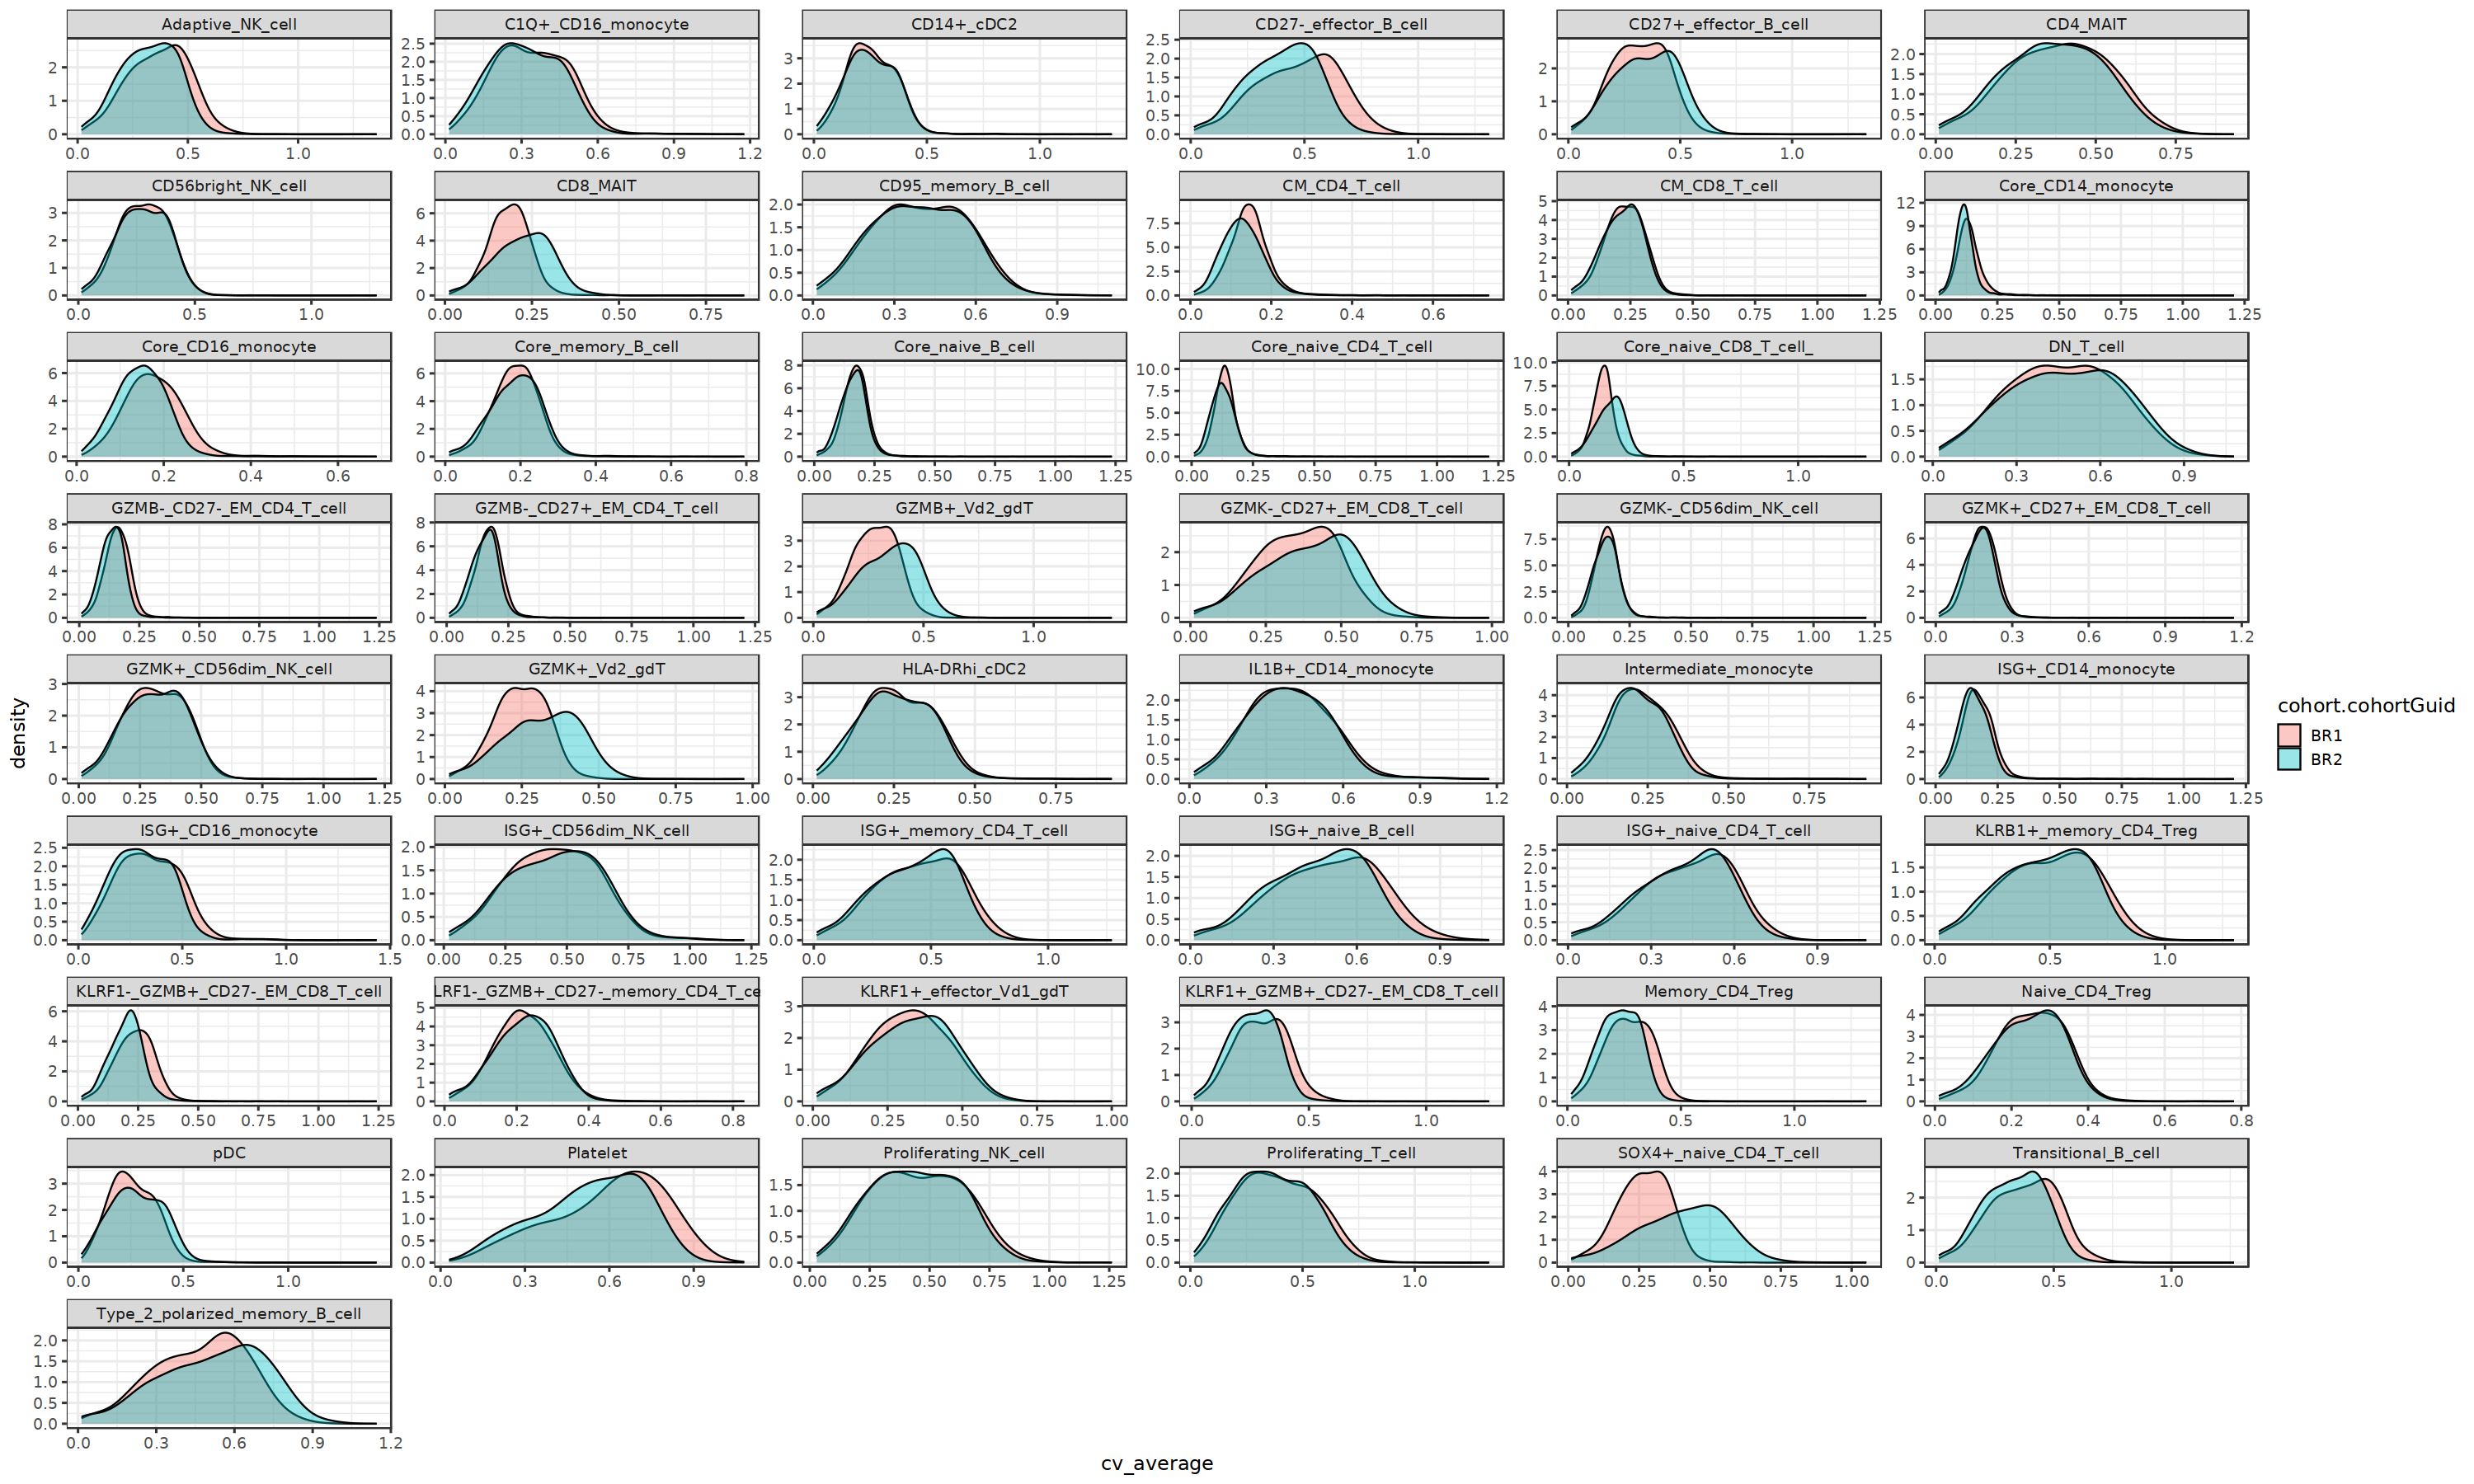

In [134]:
options(repr.plot.width = 25, repr.plot.height = 15)
P<-ggplot(data=df_all_averge, aes(x=cv_average,group=cohort.cohortGuid, fill=cohort.cohortGuid)) +
    geom_density(adjust=1.5, alpha=.4) +
    theme_bw(base_size=14)+facet_wrap(~celltypes,ncol=6,scale='free')
P

In [77]:
library(ggpubr)

In [78]:
unique(df_all_averge$celltypes)

[1] "Adaptive_NK_cell"                    
 [2] "C1Q+_CD16_monocyte"                  
 [3] "CD14+_cDC2"                          
 [4] "CD27-_effector_B_cell"               
 [5] "CD27+_effector_B_cell"               
 [6] "CD4_MAIT"                            
 [7] "CD56bright_NK_cell"                  
 [8] "CD8_MAIT"                            
 [9] "CD95_memory_B_cell"                  
[10] "CM_CD4_T_cell"                       
[11] "CM_CD8_T_cell"                       
[12] "Core_CD14_monocyte"                  
[13] "Core_CD16_monocyte"                  
[14] "Core_memory_B_cell"                  
[15] "Core_naive_B_cell"                   
[16] "Core_naive_CD4_T_cell"               
[17] "Core_naive_CD8_T_cell_"              
[18] "DN_T_cell"                           
[19] "GZMB-_CD27-_EM_CD4_T_cell"           
[20] "GZMB-_CD27+_EM_CD4_T_cell"           
[21] "GZMB+_Vd2_gdT"                       
[22] "GZMK-_CD27+_EM_CD8_T_cell"           
[23] "GZMK-_CD56dim_NK_cell"               
[24] "GZMK+_CD27+_EM_CD8_T_cell"           
[25] "GZMK+_CD56dim_NK_cell"               
[26] "GZMK+_Vd2_gdT"                       
[27] "HLA-DRhi_cDC2"                       
[28] "IL1B+_CD14_monocyte"                 
[29] "Intermediate_monocyte"               
[30] "ISG+_CD14_monocyte"                  
[31] "ISG+_CD16_monocyte"                  
[32] "ISG+_CD56dim_NK_cell"                
[33] "ISG+_memory_CD4_T_cell"              
[34] "ISG+_naive_B_cell"                   
[35] "ISG+_naive_CD4_T_cell"               
[36] "KLRB1+_memory_CD4_Treg"              
[37] "KLRF1-_GZMB+_CD27-_EM_CD8_T_cell"    
[38] "KLRF1-_GZMB+_CD27-_memory_CD4_T_cell"
[39] "KLRF1+_effector_Vd1_gdT"             
[40] "KLRF1+_GZMB+_CD27-_EM_CD8_T_cell"    
[41] "Memory_CD4_Treg"                     
[42] "Naive_CD4_Treg"                      
[43] "pDC"                                 
[44] "Platelet"                            
[45] "Proliferating_NK_cell"               
[46] "Proliferating_T_cell"                
[47] "SOX4+_naive_CD4_T_cell"              
[48] "Transitional_B_cell"                 
[49] "Type_2_polarized_memory_B_cell"

`geom_smooth()` using formula = 'y ~ x'


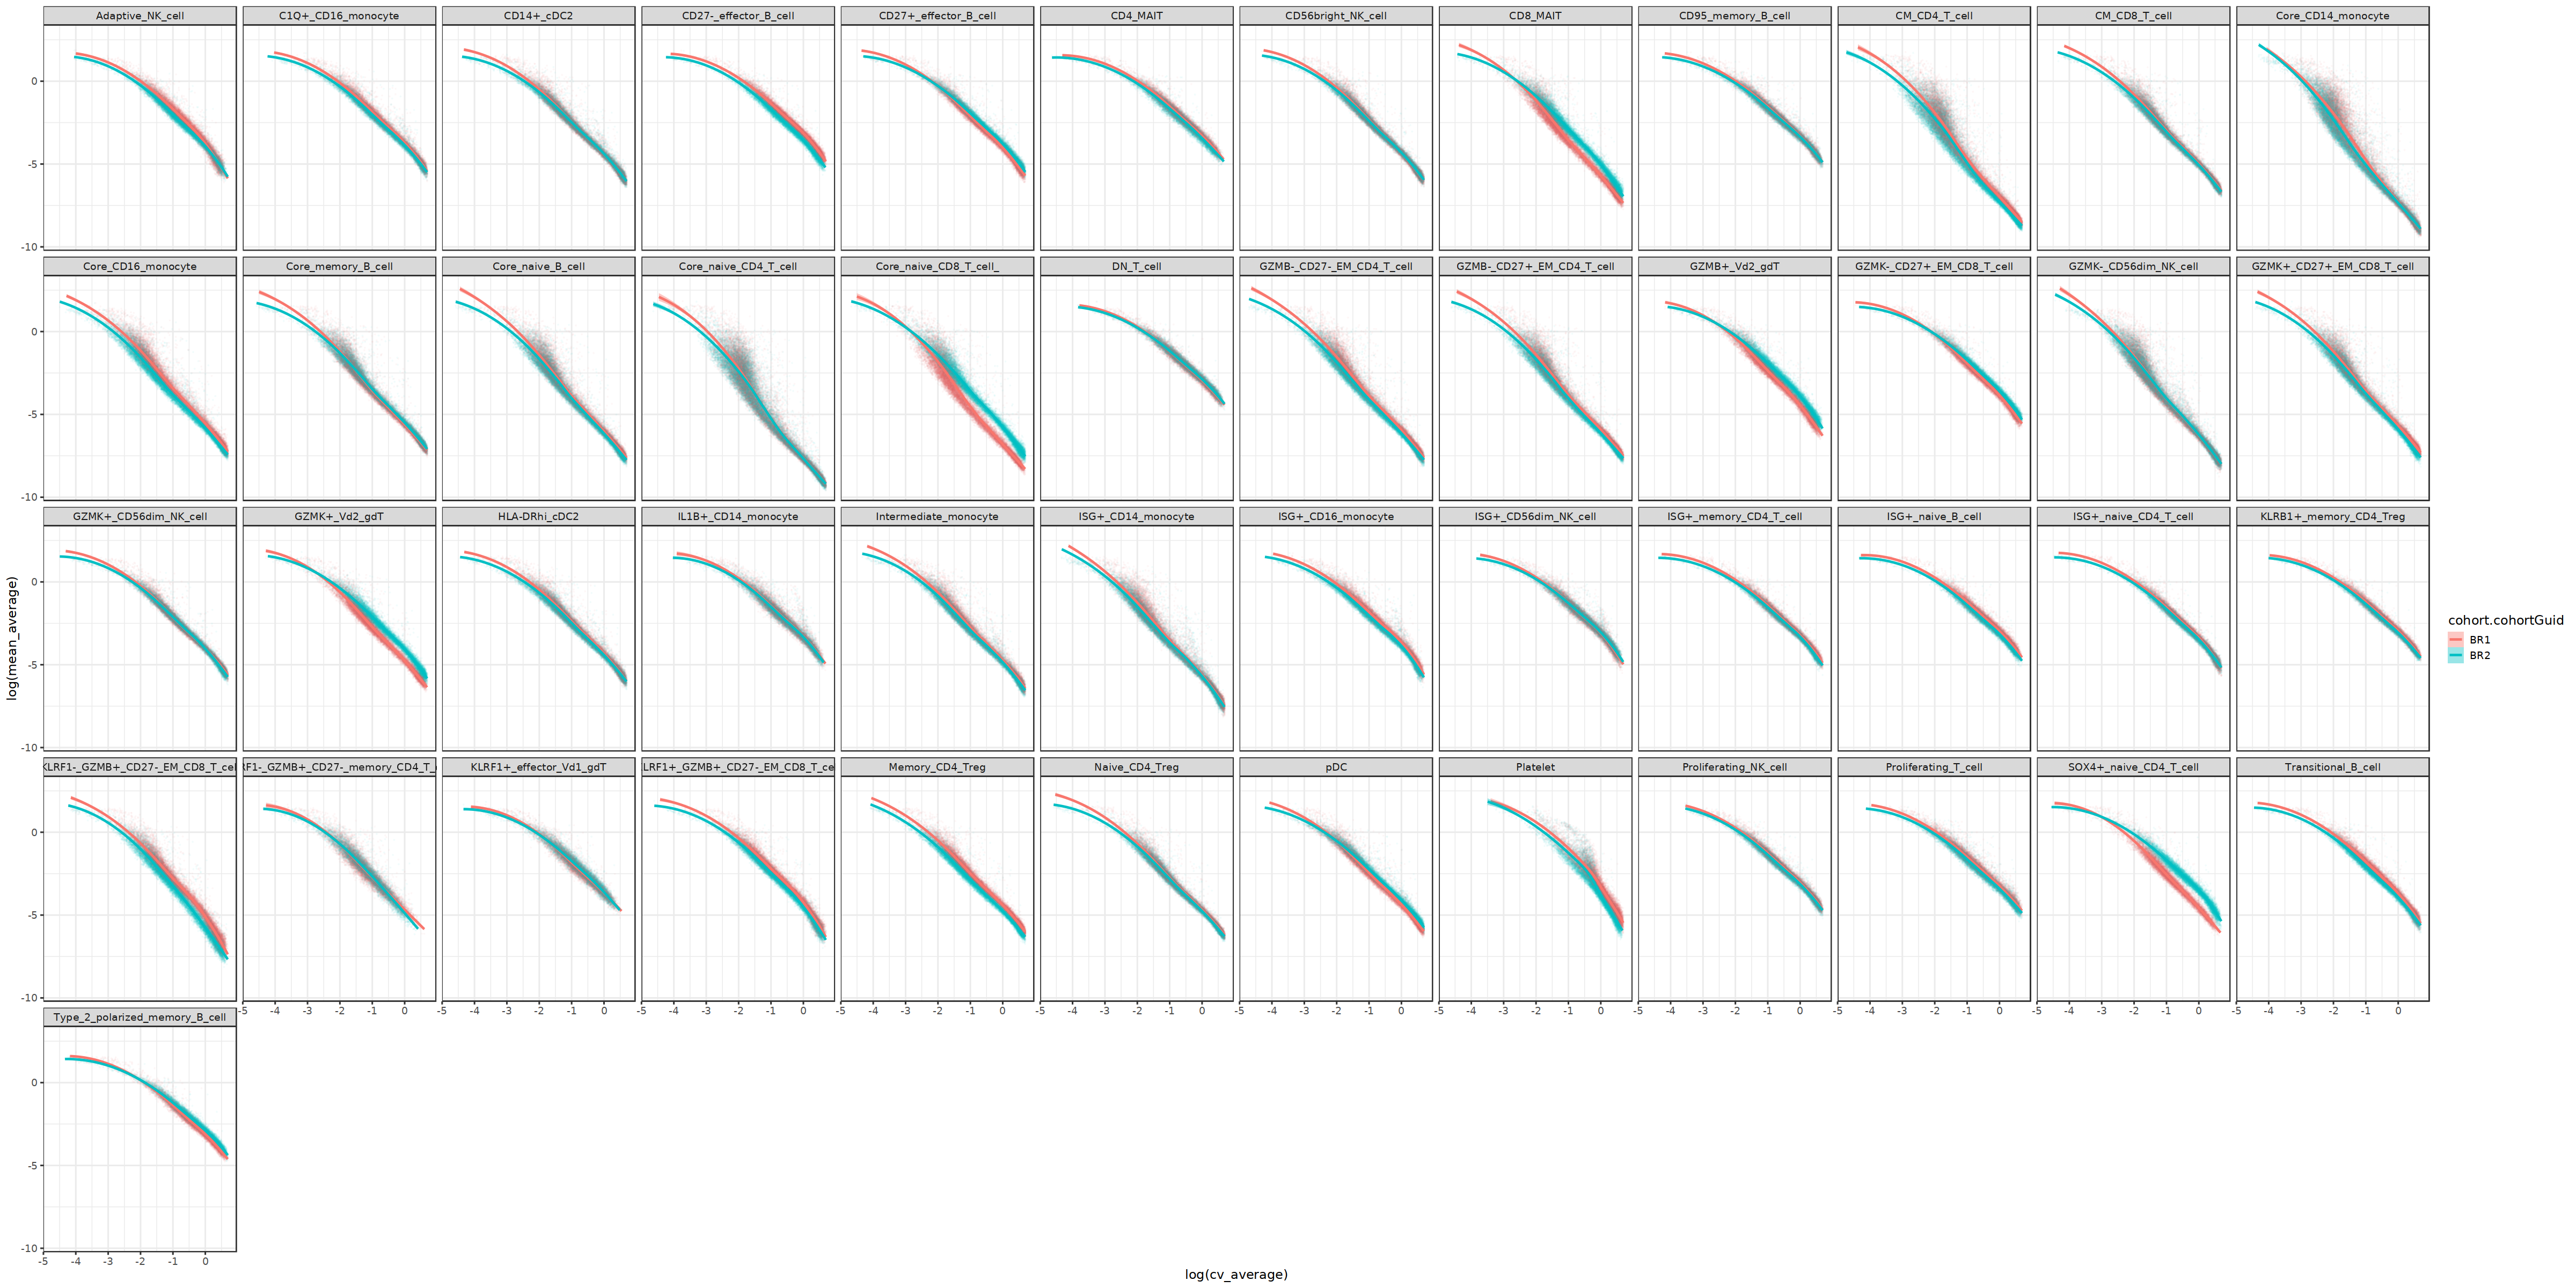

In [123]:
options(repr.plot.width = 40, repr.plot.height = 20)

p1<-ggplot(df_all_averge,#%>% filter(celltypes%in% c("CD8_MAIT",'CD95_memory_B_cell')), 
       aes(x=log(cv_average), 
           y=log(mean_average), 
            color=cohort.cohortGuid)) +
  geom_point(size=0.1,alpha=0.03) + theme_bw(base_size=14)+
  geom_smooth(method='loess', aes(fill=cohort.cohortGuid))+facet_wrap(~celltypes,ncol=12) 
p1

# Pathway analysis

In [197]:
df_all_averge %>% filter(celltypes=="Core_naive_CD4_T_cell",X=='COX5B')

celltypes,X,cohort.cohortGuid,cv_average,mean_average
<chr>,<chr>,<chr>,<dbl>,<dbl>
Core_naive_CD4_T_cell,COX5B,BR1,0.15499868,0.9261605
Core_naive_CD4_T_cell,COX5B,BR2,0.03597609,0.9956667


In [198]:
head(df_all_averge)

celltypes,X,cohort.cohortGuid,cv_average,mean_average
<chr>,<chr>,<chr>,<dbl>,<dbl>
Adaptive_NK_cell,A1BG,BR1,0.6443648,0.09755206
Adaptive_NK_cell,A1BG,BR2,0.4218518,0.08978024
Adaptive_NK_cell,A2M-AS1,BR1,0.4832482,0.12712848
Adaptive_NK_cell,A2M-AS1,BR2,0.3976931,0.11833863
Adaptive_NK_cell,AAAS,BR1,0.4101927,0.07096471
Adaptive_NK_cell,AAAS,BR2,0.5737097,0.06602669


In [182]:
log2(0.3976931/0.4832482)

[1] -0.2811088

In [181]:
head(cv_log2fc)

celltypes,X,log2fc
<chr>,<chr>,<dbl>
Adaptive_NK_cell,A1BG,-0.6111415
Adaptive_NK_cell,A2M-AS1,-0.2811089
Adaptive_NK_cell,AAAS,0.4840192
Adaptive_NK_cell,AAED1,-0.1907123
Adaptive_NK_cell,AAGAB,-0.4677763
Adaptive_NK_cell,AAK1,-0.5112714


In [150]:
cv_log2fc<- df_all_averge %>%
  group_by(celltypes, X) %>%
  filter(n() == 2) %>%
  arrange(celltypes, X, cohort.cohortGuid) %>%
  summarise(log2fc = log2(last(cv_average) / first(cv_average)))

`summarise()` has grouped output by 'celltypes'. You can override using the
`.groups` argument.


In [187]:
cv_log2fc_subset<-cv_log2fc %>% filter(celltypes=="Core_naive_CD4_T_cell") %>% arrange(desc(log2fc))

In [188]:
head(cv_log2fc_subset)

celltypes,X,log2fc
<chr>,<chr>,<dbl>
Core_naive_CD4_T_cell,YBX3,1.0610177
Core_naive_CD4_T_cell,SLC25A37,0.7868618
Core_naive_CD4_T_cell,MALAT1,0.6152585
Core_naive_CD4_T_cell,SLC2A11,0.5946803
Core_naive_CD4_T_cell,FCF1,0.5941504
Core_naive_CD4_T_cell,SAMD1,0.5832783


In [189]:
tail(cv_log2fc_subset)

celltypes,X,log2fc
<chr>,<chr>,<dbl>
Core_naive_CD4_T_cell,NDUFS5,-2.019838
Core_naive_CD4_T_cell,SNRPD2,-2.032435
Core_naive_CD4_T_cell,RPS15,-2.054355
Core_naive_CD4_T_cell,RPS25,-2.101865
Core_naive_CD4_T_cell,C12orf57,-2.105237
Core_naive_CD4_T_cell,COX5B,-2.107146


In [190]:
library(fgsea)

In [191]:
pathways_database <- gmtPathways('c2.cp.v7.2.symbols.gmt')


In [192]:
fgsea_input<-deframe(cv_log2fc_subset[c('X','log2fc')])

In [193]:
fgseaResults <- fgsea(pathways =pathways_database ,
                      stats = fgsea_input,
                      minSize = 15,
                      maxSize = 500,
                      nperm = 1000)

Warning message in fgsea(pathways = pathways_database, stats = fgsea_input, minSize = 15, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgseaSimple(pathways = pathways, stats = stats, minSize = minSize, :
“There were 4 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”


In [196]:
tail(fgsea_input)

NDUFS5    SNRPD2     RPS15     RPS25  C12orf57     COX5B 
-2.019838 -2.032435 -2.054355 -2.101865 -2.105237 -2.107146

In [194]:
fgseaResults %>% filter(padj<0.05) %>% arrange(padj)

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
KEGG_OXIDATIVE_PHOSPHORYLATION,0.000999001,0.01534641,-0.7657970,-2.074222,0,109,"COX5B , NDUFS5 , UQCRH , COX6B1 , COX7C , COX8A , COX6A1 , COX7A2 , ATP5PD , NDUFB7 , UQCRB , ATP5MG , NDUFA4 , NDUFS6 , NDUFB2 , ATP5PF , ATP5MC1 , COX6C , NDUFA2 , ATP5MC2 , NDUFB4 , NDUFA11 , ATP5MF , COX7B , UQCR11 , NDUFB9 , NDUFB10 , UQCR10 , NDUFC1 , NDUFB8 , NDUFB3 , UQCRQ , NDUFA1 , ATP5F1E , NDUFA6 , COX4I1 , NDUFB6 , ATP6V1F , COX7A2L , NDUFC2 , ATP5MC3 , ATP5PO , NDUFA3 , UQCRC2 , SDHD , ATP5F1C , NDUFS8 , NDUFA9 , ATP5F1D , NDUFB5 , NDUFB1 , ATP6V0E2, COX5A , NDUFAB1 , COX17 , CYC1 , NDUFS2 , NDUFS4 , PPA1 , SDHA , ATP5ME , ATP6V1B2"
KEGG_PYRUVATE_METABOLISM,0.001070664,0.01534641,-0.7201103,-1.739996,0,21,"LDHB , LDHA , ACYP1 , ACYP2 , MDH1 , ALDH9A1, PKM , MDH2 , ACAT2 , GRHPR , PDHB , GLO1 , AKR1B1"
KEGG_RIBOSOME,0.000999001,0.01534641,-0.8433822,-2.260593,0,85,"RPS25 , RPS15 , RPS15A , RPL28 , RPL36AL, RPL26 , RPLP1 , RPLP2 , RPL24 , RPS24 , FAU , RPL35 , UBA52 , RPL35A , RPS12 , RPS23 , RPS19 , RPS13 , RPS8 , RPS26 , RPL32 , RPS27L , RPL41 , RPS27A , RPL27 , RPL30 , RPL34 , RPS18 , RPL31 , RPL22L1, RPS10 , RPS21 , RPL36 , RPL39 , RPL11 , RPL22 , RPL37 , RPS3A , RPL23A , RPS16 , RPL36A , RPL5 , RPL18A , RPL12 , RPL23 , RPS4X , RPS28 , RPL37A , RPL38 , RPS11 , RPL21 , RPL27A , RPL3 , RPL18 , RPSA , RPL7A , RPL26L1, RPL29"
KEGG_CARDIAC_MUSCLE_CONTRACTION,0.001041667,0.01534641,-0.8088215,-2.022737,0,30,"COX5B , UQCRH , COX6B1 , COX7C , COX8A , COX6A1 , COX7A2 , UQCRB , COX6C , COX7B , UQCR11 , UQCR10 , UQCRQ , COX4I1 , COX7A2L, UQCRC2 , COX5A , CYC1"
KEGG_ALZHEIMERS_DISEASE,0.000999001,0.01534641,-0.7422003,-2.018005,0,115,"COX5B , NDUFS5 , UQCRH , COX6B1 , COX7C , COX8A , COX6A1 , COX7A2 , ATP5PD , NDUFB7 , UQCRB , NDUFA4 , NDUFS6 , NDUFB2 , ATP5PF , ATP5MC1, COX6C , NDUFA2 , ATP5MC2, NDUFB4 , COX7B , UQCR11 , NDUFB9 , NDUFB10, UQCR10 , NDUFC1 , NDUFB8 , NDUFB3 , UQCRQ , NDUFA1 , ATP5F1E, NDUFA6 , COX4I1 , NDUFB6 , COX7A2L, NDUFC2 , PSENEN , ATP5MC3, ATP5PO , NDUFA3 , UQCRC2 , SDHD , ATP5F1C, NDUFS8 , NDUFA9 , APH1A , ATP5F1D, NDUFB5 , NDUFB1 , GAPDH , COX5A , NDUFAB1, CYC1 , NDUFS2 , CHP1"
KEGG_PARKINSONS_DISEASE,0.000999001,0.01534641,-0.7607281,-2.058987,0,103,"COX5B , NDUFS5 , UQCRH , COX6B1 , COX7C , COX8A , COX6A1 , COX7A2 , ATP5PD , NDUFB7 , UQCRB , NDUFA4 , NDUFS6 , NDUFB2 , ATP5PF , ATP5MC1, COX6C , NDUFA2 , ATP5MC2, NDUFB4 , COX7B , UQCR11 , NDUFB9 , NDUFB10, UQCR10 , NDUFC1 , NDUFB8 , NDUFB3 , UQCRQ , NDUFA1 , ATP5F1E, NDUFA6 , COX4I1 , NDUFB6 , VDAC2 , COX7A2L, NDUFC2 , SLC25A5, SLC25A6, ATP5MC3, ATP5PO , NDUFA3 , UQCRC2 , SDHD , ATP5F1C, NDUFS8 , NDUFA9 , ATP5F1D, NDUFB5 , NDUFB1 , VDAC3 , COX5A , NDUFAB1, UBE2L3 , CYC1 , NDUFS2 , UBB , NDUFS4 , SDHA"
KEGG_HUNTINGTONS_DISEASE,0.000999001,0.01534641,-0.7400139,-2.016961,0,132,"COX5B , NDUFS5 , UQCRH , COX6B1 , COX7C , COX8A , COX6A1 , COX7A2 , ATP5PD , NDUFB7 , UQCRB , NDUFA4 , POLR2I , NDUFS6 , NDUFB2 , ATP5PF , ATP5MC1, COX6C , NDUFA2 , ATP5MC2, NDUFB4 , COX7B , UQCR11 , POLR2F , NDUFB9 , NDUFB10, UQCR10 , NDUFC1 , POLR2J , NDUFB8 , NDUFB3 , UQCRQ , NDUFA1 , ATP5F1E, NDUFA6 , COX4I1 , NDUFB6 , VDAC2 , COX7A2L, POLR2L , NDUFC2 , SLC25A5, TFAM , SLC25A6, ATP5MC3, ATP5PO , NDUFA3 , UQCRC2 , SDHD , ATP5F1C, NDUFS8 , NDUFA9 , ATP5F1D, NDUFB5 , NDUFB1 , VDAC3 , COX5A , NDUFAB1, SOD1 , CYC1 , HDAC1 , NDUFS2"
PID_HIF1A_PATHWAY,0.001111111,0.01534641,-0.7976645,-1.819252,0,15,"ELOB , RBX1 , RACK1, ELOC , COPS5"
REACTOME_RECOGNITION_OF_DNA_DAMAGE_BY_PCNA_CONTAINING_REPLICATION_COMPLEX,0.001061571,0.01534641,-0.7438371,-1.819522,0,23,"UBA52 , RPS27A, RBX1 , POLE4 , POLE3 , UBC , RPA3 , RPA2 , UBB , PCNA , RFC4"
